In [3]:
import pytreenet as ptn
import numpy as np
import matplotlib.pyplot as plt

# Exact (Qutip)

In [4]:
# System initialization
t = 1
u = 1
mu = 0.5
Lx = 4
Ly = 4
n_bosons = 2
system = ptn.BoseHubbard2D_Qutip(Lx, Ly, n_bosons, t, u, mu)

# Create initial state
black_state = np.array([0,1])
white_state = np.array([1,0])
psi0 = system.alternating_product_state(black_state, white_state, pattern= "checkerboard")
#psi0 = system.uniform_product_state([1/np.sqrt(2), 1/np.sqrt(2)])
# Evolve system
end_time = 2
dt = 0.01
result = system.evolve_system(psi0, end_time=end_time, dt=dt)


# 2TDVP on MPS (TenPy)

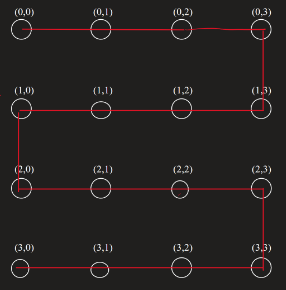

In [5]:
# Set up parameters
Lx = 4
Ly = 4
n_bosons = 2
t = 1
U = 1
mu = 0.5

# Create model and initial state
model = ptn.BoseHubbard2D_Tenpy(Lx, Ly, n_bosons, t, U, mu)
black_state = [0, 1]  # |0>
white_state = [1, 0]  # |1>
mps = model.alternating_product_state_custom(black_state, white_state, pattern="checkerboard")

# Print initial state energy
print("Initial energy:", model.H_MPO.expectation_value(mps))

# Print initial occupation for a few sites
print("Initial occupations:")
occ_initial = model.calculate_occupation(mps)
print(occ_initial)  # Print first 2x2 corner

# Evolution parameters
lanczos_params = {
    'N_min': 2,           # Min number of Lanczos steps per /5
    'N_max': 20,          # Max number of Lanczos steps per evolution step/20
    'P_tol': 1e-6,       # Tolerance for convergence in Lanczos /1e-14
    'reortho': False}     # Reorthogonalize vectors in the Krylov space /False
   

# Evolve the state
psi_evolved = model.evolve_system_two_site(mps, 
                                           end_time = 2,
                                           dt = 0.01, 
                                           chi_max = 80, 
                                           svd_min = 1e-4, 
                                           lanczos_params=lanczos_params) 

Initial energy: 0.0
Initial occupations:
[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]]


# TDVP 

# Spanning Tree

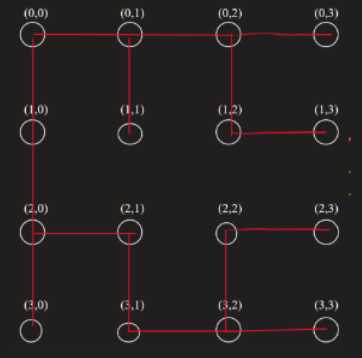

In [24]:
d = 2

shapes = {
    (0, 0): (2, 2, d),
    (0, 1): (2, 2, 2, d),
    (0, 2): (2, 2, 2, d),
    (0, 3): (2, d),
    (1, 0): (2, 2, d),
    (1, 1): (2, d),
    (1, 2): (2, 2, d),
    (1, 3): (2, d),
    (2, 0): (2, 2, 2, d),
    (2, 1): (2, 2, d),
    (2, 2): (2, 2, d),
    (2, 3): (2, d),
    (3, 0): (2, d),
    (3, 1): (2, 2, d),
    (3, 2): (2, 2, 2, d),
    (3, 3): (2, d)
}

nodes = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(4) for j in range(4)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(nodes[(0, 0)][0], nodes[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 1), (1, 1), 1, 0),
    ((0, 1), (0, d), 2, 0),
    ((0, 2), (1, 2), 1, 0),
    ((1, 2), (1, 3), 1, 0),
    ((0, 2), (0, 3), 2, 0),
    ((0, 0), (1, 0), 1, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (3, 0), 1, 0),
    ((2, 0), (2, 1), 2, 0),
    ((2, 1), (3, 1), 1, 0),
    ((3, 1), (3, 2), 1, 0),
    ((3, 2), (2, 2), 1, 0),
    ((2, 2), (2, 3), 1, 0),
    ((3, 2), (3, 3), 2, 0)]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)

# Initialize state

In [48]:
local_state = np.array([0,1])
ttn = ptn.uniform_product_state(ttn ,local_state, bond_dim= 2)

black_state = np.array([0,1])
white_state = np.array([1,0])
ttn = ptn.alternating_product_state(ttn, black_state, white_state, bond_dim = 2,  pattern = "checkerboard")

In [49]:
t = 1
u = 1
m = 0.5
Lx = 4
Ly = 4

H1 = ptn.BoseHubbard_ham(t, u, m, Lx, Ly, d)
H1 = H1.pad_with_identities(ttn , symbolic= True)
ttno = ptn.TTNO.from_hamiltonian(H1, ttn)

Correlation_function = ptn.Correlation_function("Site(0,0)", "Site(2,0)", 2)
Correlation_function = Correlation_function.pad_with_identities(ttn, symbolic= True)
Correlation_function = ptn.TTNO.from_hamiltonian(Correlation_function, ttn)

In [50]:
lanczos_params =  {'N_min': 2,   
                   'N_max': 40,           
                   'P_tol': 1e-8,          
                   'reortho': True,}

expansion_params = {"ExpansionMode": ptn.ExpansionMode.TTN,
                    "num_vecs": 3, 
                    "tau": 1e-2,
                    "SVDParameters": ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= -np.inf , total_tol = -np.inf),
                    "expansion_steps": 30,
                    "tol": 1e-20,
                    "tol_step": 50,
                    "max_bond": 160,
                    "rel_tot_bond": 30,
                    "T3N_dict" : {"Site(0,1)" : "Site(0,2)",
                                  "Site(0,2)" : "Site(0,3)",
                                  "Site(2,0)" : "Site(3,0)",
                                  "Site(3,2)" : "Site(3,3)"}}

config= ptn.TTNTimeEvolutionConfig(record_bond_dim = True,
                                   Lanczos_evolution= False,
                                   Lanczos_params = lanczos_params,
                                   Expansion_params = expansion_params)

tdvp = ptn.SecondOrderOneSiteTDVP(initial_state = ttn,
                                 hamiltonian = ttno,
                                 time_step_size = 0.01,
                                 final_time = 2,
                                 operators = [Correlation_function],
                                 config = config)


In [51]:
tdvp.RUN(evaluation_time=2)
times = tdvp.times()

 15%|█▌        | 31/201 [00:02<00:14, 11.57it/s]

tol : 1e-20
SVD MAX: 5
tol: 1e-20
expanded_dim : 29 : 75 ---> 104


 30%|███       | 61/201 [00:08<00:29,  4.67it/s]

tol : 1e-20
SVD MAX: 17
tol: 1e-20
EXPANSIONED DIM > REL: 76
TRY: tol 4.999999999999999e-19
TRY: EXPANSIONED DIM : 52
TRY: tol 2.4999999999999996e-17


 31%|███       | 62/201 [00:10<01:12,  1.92it/s]

TRY: EXPANSIONED DIM : 6
expanded_dim : 6 : 104 ---> 110


 46%|████▌     | 92/201 [00:18<00:29,  3.72it/s]

tol : 2.4999999999999996e-17
SVD MAX: 18
tol: 2.4999999999999996e-17


 46%|████▋     | 93/201 [00:19<00:38,  2.81it/s]

expanded_dim : 11 : 110 ---> 121


 61%|██████    | 123/201 [00:32<00:45,  1.70it/s]

tol : 2.4999999999999996e-17
SVD MAX: 22
tol: 2.4999999999999996e-17


 62%|██████▏   | 124/201 [00:33<00:52,  1.48it/s]

expanded_dim : 13 : 121 ---> 134


 77%|███████▋  | 154/201 [01:04<00:57,  1.22s/it]

tol : 2.4999999999999996e-17
SVD MAX: 26
tol: 2.4999999999999996e-17


 77%|███████▋  | 155/201 [01:06<01:08,  1.49s/it]

expanded_dim : 12 : 134 ---> 146


 92%|█████████▏| 185/201 [01:49<00:21,  1.33s/it]

tol : 2.4999999999999996e-17
SVD MAX: 30
tol: 2.4999999999999996e-17


 93%|█████████▎| 186/201 [01:51<00:23,  1.54s/it]

expanded_dim : 12 : 146 ---> 158


100%|██████████| 201/201 [02:20<00:00,  1.43it/s]


In [14]:
correlation_exact, eval_times = system.specific_site_correlation_results(evaluation_time=2,
                                                                     results=result ,
                                                                     site1 = (0,0),
                                                                     site2 = (2,0),
                                                                     normalize = False)

correlation_tenpy, times = model.specific_site_correlation_results(psi_list=psi_evolved,
                                                                evaluation_time=2,
                                                                site1= (0,0),
                                                                site2= (2,0),
                                                                Normalize=False,
                                                                dt=0.01)

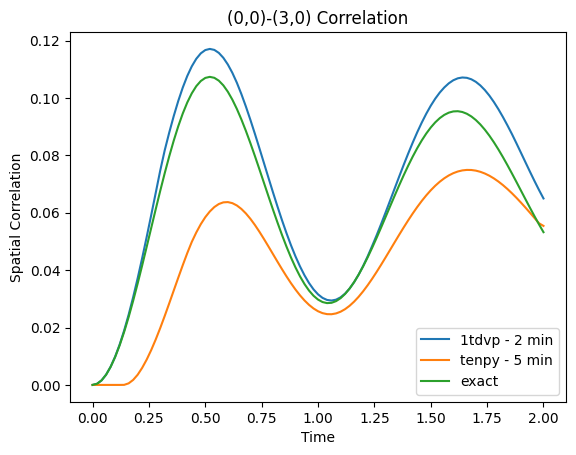

In [53]:
plt.plot(times, abs(tdvp.operator_results()[0]), label="1tdvp - 2 min")
plt.plot(times, correlation_tenpy, label="tenpy - 5 min")
plt.plot(times, correlation_exact, label="exact")

plt.title("(0,0)-(3,0) Correlation")
plt.xlabel("Time")
plt.ylabel("Spatial Correlation")
plt.legend()
plt.show()